In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)
np.set_printoptions(threshold=999)

# Construct the sample network given in the paper

In [21]:
import random
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Number of nodes to generate for each type
num_parties = 50
num_claims = 50

# Generate nodes for parties
for i in range(1, num_parties + 1):
    G.add_node(f"P{i}", 
               claims=random.randint(1, 1000),
               fraudulent=random.randint(0, 10),
               non_fraudulent=random.randint(0, 10),
               bipartite=0)

# Generate nodes for claims
for i in range(1, num_claims + 1):
    G.add_node(f"C{i}", 
               label=random.choice(["unknown", "no_fraud", "fraud"]),
               bipartite=1)

# Generate edges between party nodes and claim nodes
edges = []
for party_node in range(1, num_parties + 1):
    # Determine the number of edges for this party node
    num_edges = random.randint(1, min(10, num_claims))
    # Sample claims to connect to
    claim_nodes = random.sample(range(1, num_claims + 1), min(num_edges, 4))
    # Add edges to the list
    edges.extend([(f"P{party_node}", f"C{claim_node}", 1) for claim_node in claim_nodes])

# Make sure each node has at least one edge
for claim_node in range(1, num_claims + 1):
    if not G.degree[f"C{claim_node}"]:
        party_node = random.randint(1, num_parties)
        G.add_edge(f"P{party_node}", f"C{claim_node}", weight=1)  # Set weight to 1

# Add edges to the graph
G.add_weighted_edges_from(edges)

# Print the nodes and edges added
print("Nodes:")
print(G.nodes(data=True))
print("\nEdges:")
print(G.edges(data=True))


Nodes:
[('P1', {'claims': 729, 'fraudulent': 6, 'non_fraudulent': 0, 'bipartite': 0}), ('P2', {'claims': 772, 'fraudulent': 6, 'non_fraudulent': 9, 'bipartite': 0}), ('P3', {'claims': 648, 'fraudulent': 5, 'non_fraudulent': 8, 'bipartite': 0}), ('P4', {'claims': 740, 'fraudulent': 9, 'non_fraudulent': 1, 'bipartite': 0}), ('P5', {'claims': 913, 'fraudulent': 2, 'non_fraudulent': 5, 'bipartite': 0}), ('P6', {'claims': 889, 'fraudulent': 10, 'non_fraudulent': 8, 'bipartite': 0}), ('P7', {'claims': 977, 'fraudulent': 1, 'non_fraudulent': 6, 'bipartite': 0}), ('P8', {'claims': 374, 'fraudulent': 1, 'non_fraudulent': 0, 'bipartite': 0}), ('P9', {'claims': 725, 'fraudulent': 5, 'non_fraudulent': 6, 'bipartite': 0}), ('P10', {'claims': 967, 'fraudulent': 4, 'non_fraudulent': 9, 'bipartite': 0}), ('P11', {'claims': 509, 'fraudulent': 2, 'non_fraudulent': 6, 'bipartite': 0}), ('P12', {'claims': 477, 'fraudulent': 5, 'non_fraudulent': 4, 'bipartite': 0}), ('P13', {'claims': 21, 'fraudulent': 5, 

# Birank - Normalize Edgeweights
Birank normalizes the edge weights by the degree of the two adjacent nodes:
$$
Edge(u,v) = \frac{1}{\sqrt{deg(u)}\sqrt{deg(v)}}
$$

The effect is that the edges between nodes of high degrees, i.e. edge('P3, 'C1') = 0.2887 is lower than the nodes between nodes of lower degrees i.e. edge('P3', 'C3') = 0.356.  
During the calculation of the birank scores the updates will taken into account. So `Workshops`, `Claim Handler` and other `Involved Parties` with high degrees nodes's contribution to the birank score will be dampened.

In [22]:
for u, v, d in G.edges(data=True):
    d['weight'] = d['weight'] / np.sqrt(G.degree[u] * G.degree[v])
    print( (u, G.degree[u], v, G.degree[v]), d)

('P1', 5, 'C11', 3) {'weight': 0.2581988897471611}
('P1', 5, 'C2', 7) {'weight': 0.1690308509457033}
('P1', 5, 'C3', 3) {'weight': 0.2581988897471611}
('P1', 5, 'C33', 6) {'weight': 0.18257418583505536}
('P1', 5, 'C37', 7) {'weight': 0.1690308509457033}
('P2', 6, 'C3', 3) {'weight': 0.23570226039551587}
('P2', 6, 'C22', 3) {'weight': 0.23570226039551587}
('P2', 6, 'C36', 6) {'weight': 0.16666666666666666}
('P2', 6, 'C26', 5) {'weight': 0.18257418583505536}
('P2', 6, 'C47', 8) {'weight': 0.14433756729740646}
('P2', 6, 'C21', 6) {'weight': 0.16666666666666666}
('P3', 3, 'C46', 4) {'weight': 0.2886751345948129}
('P3', 3, 'C25', 3) {'weight': 0.3333333333333333}
('P3', 3, 'C16', 6) {'weight': 0.23570226039551587}
('P4', 4, 'C4', 6) {'weight': 0.20412414523193154}
('P4', 4, 'C45', 6) {'weight': 0.20412414523193154}
('P4', 4, 'C24', 3) {'weight': 0.2886751345948129}
('P4', 4, 'C37', 7) {'weight': 0.1889822365046136}
('P5', 4, 'C11', 3) {'weight': 0.2886751345948129}
('P5', 4, 'C36', 6) {'wei

$$
claimsbirank_j = \alpha \sum_{i=1}^{|P|} \frac{1}{\sqrt{deg(u)}\sqrt{deg(v)}}p_i + (1-\alpha)c^0_j,  
partiesbirank_i = \beta \sum_{j=1}^{|C|} \frac{1}{\sqrt{deg(u)}\sqrt{deg(v)}}c_j
$$

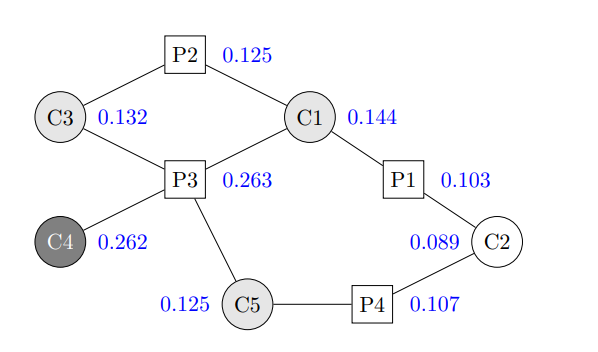

In [25]:
G.edges[('P50', 'C29')]

{'weight': 0.3779644730092272}

In [26]:
from networkx.algorithms import bipartite


print(bipartite.is_bipartite(G))
c = bipartite.color(G)
nodes = list(bipartite.color(G).keys())

color_map = {
    0: 'lightgreen',
    1: 'lightblue'
}
values = [color_map.get(value) for value in c.values()]
values

True


['lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightblue',
 'lightgreen',
 'lightgreen',
 'lightgreen',
 'lightblue',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightblue',
 'lightblue',
 'lightgreen',
 'lightblue',
 'lightblue',
 '

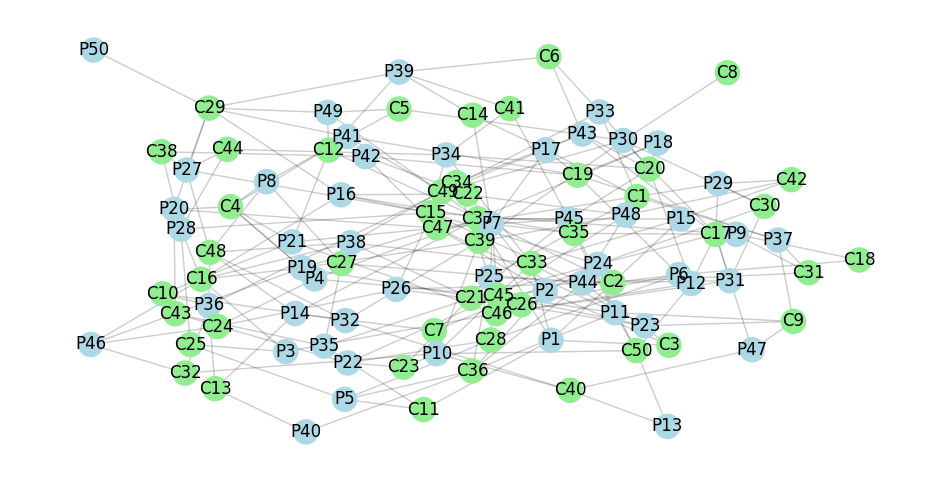

In [27]:
import networkx as nx
from networkx.algorithms import bipartite


plt.figure(figsize=(12,6))
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color = values)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.show()

Export it as an Edgelist so that we can use calculate birank scores

In [28]:
edgelist_df_small_example = bipartite.edgelist.write_edgelist(G, 'edgelist_df_small_example', data=False)
edgelist_df_small_example

In [29]:
edgelist_df = pd.read_csv("edgelist_df_small_example", names=['Parties', 'Claims'], delim_whitespace=True)
edgelist_df

/var/folders/nm/ynhs3n3n01xg3_gnpyzd51w80000gn/T/ipykernel_9534/3916289679.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  edgelist_df = pd.read_csv("edgelist_df_small_example", names=['Parties', 'Claims'], delim_whitespace=True)


,Parties,Claims
0,P1,C11
1,P1,C2
2,P1,C3
3,P1,C33
4,P1,C37
...,...,...
216,P49,C37
217,P49,C5
218,P49,C12
219,P49,C29


In [30]:
G.edges(data=True)

EdgeDataView([('P1', 'C11', {'weight': 0.2581988897471611}), ('P1', 'C2', {'weight': 0.1690308509457033}), ('P1', 'C3', {'weight': 0.2581988897471611}), ('P1', 'C33', {'weight': 0.18257418583505536}), ('P1', 'C37', {'weight': 0.1690308509457033}), ('P2', 'C3', {'weight': 0.23570226039551587}), ('P2', 'C22', {'weight': 0.23570226039551587}), ('P2', 'C36', {'weight': 0.16666666666666666}), ('P2', 'C26', {'weight': 0.18257418583505536}), ('P2', 'C47', {'weight': 0.14433756729740646}), ('P2', 'C21', {'weight': 0.16666666666666666}), ('P3', 'C46', {'weight': 0.2886751345948129}), ('P3', 'C25', {'weight': 0.3333333333333333}), ('P3', 'C16', {'weight': 0.23570226039551587}), ('P4', 'C4', {'weight': 0.20412414523193154}), ('P4', 'C45', {'weight': 0.20412414523193154}), ('P4', 'C24', {'weight': 0.2886751345948129}), ('P4', 'C37', {'weight': 0.1889822365046136}), ('P5', 'C11', {'weight': 0.2886751345948129}), ('P5', 'C36', {'weight': 0.20412414523193154}), ('P5', 'C28', {'weight': 0.25}), ('P5',

In [16]:
G.edges[('P4', 'C2')]
# G.edges[('P1', 'C2')]['weight']

{'weight': 0.5}

In [31]:
def get_edgeweight(G, x):
    '''
    Returns the edge weight of a weighted graph
    
    Inputs:
        G::nx.Graph: NetworkX Graph with edge_weight attributes set to 'weight'
        x::pd.DataFrame: Edgelist DataFrame with first column the Source, second column the Dest
        
    Returns:
        pd.Series of the edgeweights between col1, col2 for every row in the DataFrame
    '''
    u, v = x[0], x[1]
    return G.edges[(u, v)]['weight']

edgelist_df['Weight'] = edgelist_df.apply(lambda x: get_edgeweight(G, x), axis=1)
edgelist_df

/var/folders/nm/ynhs3n3n01xg3_gnpyzd51w80000gn/T/ipykernel_9534/683384911.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  u, v = x[0], x[1]


,Parties,Claims,Weight
0,P1,C11,0.258199
1,P1,C2,0.169031
2,P1,C3,0.258199
3,P1,C33,0.182574
4,P1,C37,0.169031
...,...,...,...
216,P49,C37,0.188982
217,P49,C5,0.288675
218,P49,C12,0.250000
219,P49,C29,0.188982


# 1. Birank Algorithm

In [32]:
import pandas as pd
import numpy as np
import scipy.sparse as spa


class Bipartite:
    """
    Class for handling bipartite networks using scipy's sparse matrix
    """
    def __init__(self):
        pass

    def set_edgelist(self, df, parties_col, claims_col, weight_col=None):
        """
        Method to set the edgelist.

        Input:
            df::pandas.DataFrame: the edgelist with at least two columns
            parties_col::string: column of the edgelist dataframe for Involved Parties nodes
            claims_col::string: column of the edgelist dataframe for Claims nodes
            weight_col::string: column of the edgelist dataframe for edge weights

        The edgelist should be represented by a dataframe.
        The dataframe needs at least two columns for the Involed Parties nodes and
        Claims nodes. An optional column can carry the edge weight.
        You need to specify the columns in the method parameters.
        """
        self.df = df
        self.parties_col = parties_col
        self.claims_col = claims_col
        self.weight_col = weight_col

        self._index_nodes()
        self._generate_adj()
    
    def generate_degree(self):
        """
        This method returns the degree of nodes in the bipartite network
        """
        parties_df = self.df.groupby(self.parties_col)[self.claims_col].nunique()
        parties_df = parties_df.to_frame(name='degree').reset_index()
        claims_df = self.df.groupby(self.claims_col)[self.parties_col].nunique()
        claims_df = claims_df.to_frame(name='degree').reset_index()
        return parties_df, claims_df
    
    def _index_nodes(self):
        """
        Representing the network with adjacency matrix requires indexing the parties
        and claims nodes
        """
        
        self.parties_ids = pd.DataFrame(
            self.df[self.parties_col].unique(),
            columns=[self.parties_col]
        ).reset_index()
        self.parties_ids = self.parties_ids.rename(columns={'index': 'parties_index'})
        
        self.claims_ids = pd.DataFrame(
            self.df[self.claims_col].unique(),
            columns=[self.claims_col]
        ).reset_index()
        self.claims_ids = self.claims_ids.rename(columns={'index': 'claims_index'})

        self.df = self.df.merge(self.parties_ids, on=self.parties_col)
        self.df = self.df.merge(self.claims_ids, on=self.claims_col)

    def _generate_adj(self):
        """
        Generating the adjacency matrix for the birparite network.
        The matrix has dimension: D * P where D is the number of top nodes
        and P is the number of bottom nodes
        """
        if self.weight_col is None:
            # set weight to 1 if weight column is not present
            weight = np.ones(len(self.df))
        else:
            weight = self.df[self.weight_col]
        self.W = spa.coo_matrix(
            (
                weight,
                (self.df['parties_index'].values, self.df['claims_index'].values)
            )
        )


    def generate_birank(self, normalizer='BiRank',
    alpha=0.85, beta=1, max_iter=500, tol=1.0e-5, prior=[], verbose=False):
        """
        Calculate the Fraud Score of bipartite networks directly.
        See paper https://arxiv.org/pdf/2009.08313.pdf
        for details.
        HITS, CoHITS, BGRM, BiRank Normalizer's implemented
        See paper https://ieeexplore.ieee.org/abstract/document/7572089/
        for details.

        Input:
            W::scipy's sparse matrix:Adjacency matrix of the bipartite network P*C
            normalizer::string:Choose which normalizer to use, see the paper for details
            alpha, beta::float:Damping factors for the rows and columns
            max_iter::int:Maximum iteration times. Set max_iter to 0 or 1 to return the prior_vector and prior
            tol::float:Error tolerance to check convergence 
            prior::list: List of integers of known fradulent claims, e.g. Claim1, Claim3 Fraudulent -> [1,3]
            p: query vector for BiRank algorithm will then be arr, 1 at index prior-1, 0 otherwise, e.g. [1,0,1,0,0]
            verbose::boolean:If print iteration information

        Output:
             p, c::numpy.ndarray:BiRank scores for Parties and Claims
        """
        W = self.W
        df = self.df
        W = W.astype('float', copy=False)
        WT = W.T

        Kp = np.array(W.sum(axis=1)).flatten()
        Kc = np.array(W.sum(axis=0)).flatten()

        # avoid divided by zero issue
        Kp[np.where(Kp==0)] += 1
        Kc[np.where(Kc==0)] += 1

        # Normalizing the W weight matrix
        Kp_ = spa.diags(1/Kp)
        Kc_ = spa.diags(1/Kc)
        if normalizer == 'HITS':
            Sc = WT
            Sp = W
        elif normalizer == 'CoHITS':
            Sc = WT.dot(Kp_)
            Sp = W.dot(Kc_)
        elif normalizer == 'BGRM':
            Sc = Kc_.dot(WT).dot(Kp_)
            Sp = Sc.T
        elif normalizer == 'BiRank':
            Kp_bi = spa.diags(1/np.lib.scimath.sqrt(Kp))
            Kc_bi = spa.diags(1/np.lib.scimath.sqrt(Kc))
            Sc = Kc_bi.dot(WT).dot(Kp_bi)
            Sp = Sc.T
        # Sc and Sp are symmetric normalized weight matrix

        # Generate prior vector

        claims_col = self.claims_col
        claims_id = self.claims_ids.copy()
        claims_id['prior_from_prior'] = np.where(claims_id[claims_col].isin(prior), 1, 0)

        mask = claims_id[claims_col].isin(prior)
        prior_df_temp = claims_id[mask]

        prior_vector = np.zeros(len(claims_id))
        indices_to_put_prior = prior_df_temp['claims_index'].values
        np.put( prior_vector, indices_to_put_prior, np.ones(len(indices_to_put_prior)) )
        print( "No. of known prior fraudulent flags:", sum(prior_vector), "Length of prior_vector:", len(prior_vector) )

        claims_id['prior_from_setting_indices'] = prior_vector

        mask = claims_id['prior_from_setting_indices'] != claims_id['prior_from_prior']
        if claims_id[mask].shape[0] > 0:
            print("Prior vector not correctly set!")
            return prior_vector, prior

        parties_id = self.parties_ids.copy()
        # p: Parties (0 vector), c: Claims (prior)
        p0 = np.zeros(Kp_.shape[0])
        p_last = p0.copy()
        c0 = prior_vector
        c_last = c0.copy()

        if max_iter == 0 or max_iter == 1:
            print('Earning Stopping Warning: max_iter is {max_iter}'.format(max_iter=max_iter))
            c = c0
            p = p0
            return p, c

        for i in range(max_iter):
            c = alpha * (Sc.dot(p_last)) + (1-alpha) * c0
            p = beta * (Sp.dot(c_last)) + (1-beta) * p0

            if normalizer == 'HITS':
                c = c / c.sum()
                p = p / p.sum()

            err_c = np.absolute(c - c_last).sum()
            err_p = np.absolute(p - p_last).sum()
            if verbose:
                print(
                    "Iteration : {}; top error: {}; bottom error: {}".format(
                        i, err_p, err_c
                    )
                )
            if err_c < tol and err_p < tol:
                break
            p_last = p
            c_last = c
        parties_id['birank_score'] = p
        claims_id['birank_score'] = c
        return (parties_id[[self.parties_col, 'birank_score']],
                claims_id[[self.claims_col, 'birank_score']])

In [76]:
bn = Bipartite()
bn.set_edgelist(edgelist_df,  parties_col='Parties', claims_col='Claims')

prior = [node for node in G.nodes if G.nodes[node].get('label') == 'fraud']
parties_birank, claims_birank = bn.generate_birank(normalizer="BiRank", alpha=0.85, beta=1, prior=prior, max_iter=500, tol=1.0e-4, verbose=False)

No. of known prior fraudulent flags: 15.0 Length of prior_vector: 50


In [77]:
claims_birank

,Claims,birank_score
0,C11,0.158467
1,C2,0.297958
2,C3,0.342682
3,C33,0.255063
4,C37,0.310250
5,C22,0.185892
6,C36,0.261084
7,C26,0.420991
8,C47,0.305166
9,C21,0.247128


In [78]:
parties_birank

,Parties,birank_score
0,P1,0.278768
1,P2,0.330195
2,P3,0.172450
3,P4,0.312697
4,P5,0.193439
5,P6,0.332657
6,P7,0.301684
7,P8,0.260208
8,P9,0.315118
9,P10,0.302902


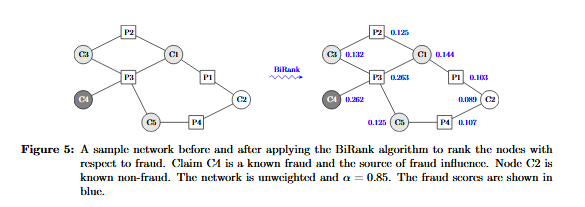

## 1.1 Checking the correctness of birank_scores

Notation:  
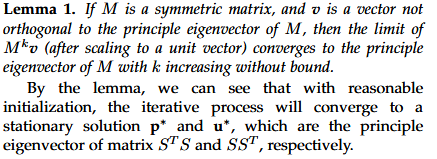  
**p*** are the principle eigenvector of ($S^{T}S$) = `claims_birank`  
**u***are the principle eigenvector of ($SS^{T}$) = `parties_birank`   

In [79]:
p = claims_birank['birank_score'].values # p vector is the principal eigenvecctor of matrix S^T*S
u = parties_birank['birank_score'].values

W = bn.W.astype('float', copy=False)
WT = W.T

# Ku = scipy.array(W.sum(axis=1)).flatten()
# Kp = scipy.array(W.sum(axis=0)).flatten()

Ku = np.array(W.sum(axis=1)).flatten()
Kp = np.array(W.sum(axis=0)).flatten()


# avoid divided by zero issue
#Ku[np.where(Ku==0)] += 1
#Kp[np.where(Kp==0)] += 1

# Normalizing the W weight matrix
Ku_ = spa.diags(1/Ku)
Kp_ = spa.diags(1/Kp)

# BiRank Normalization
Ku_bi = spa.diags(1/np.sqrt(Ku))
Kp_bi = spa.diags(1/np.sqrt(Kp))
Sp = Kp_bi.dot(WT).dot(Ku_bi) # S^T
Su = Sp.T # S

ST_S = Sp.dot(Su)
S_ST = Su.dot(Sp)
print(ST_S.shape, S_ST.shape)

(50, 50) (50, 50)


We define $$M: \alpha\beta[S^TS]$$ and by theorem 1: M's eigenvalues are bounded by $$[-\alpha\beta, \alpha\beta]$$  

Recall:  
p is principal eigenvector of ST_S (Sc @ Sp),  
u is principal eigenvector of SS_T (Sp @ Sc)

$$
Ax = \lambda x
$$
is the form 
$$
p \cdot S^{T}S = \lambda \cdot S^{T}S
$$
In our case since we specified $\alpha=0.85, \beta=1$, the bound is $[-0.85, 0.85]$

In [80]:
eigenvalues, eigenvectors = np.linalg.eig(0.85 * S_ST.todense())
print(eigenvalues)
print(np.min(eigenvalues), np.max(eigenvalues))

[8.500e-01 5.397e-01 4.880e-01 4.841e-01 4.550e-01 4.401e-01 4.051e-01
 3.998e-01 3.730e-01 3.559e-01 3.507e-01 3.280e-01 2.996e-01 2.910e-01
 2.741e-01 2.509e-01 2.373e-01 2.292e-01 2.241e-01 2.228e-01 2.079e-01
 1.991e-01 1.684e-01 1.615e-01 1.449e-01 1.351e-01 1.203e-01 1.044e-01
 1.026e-01 9.051e-02 8.146e-02 7.709e-02 7.319e-02 6.121e-02 5.156e-02
 4.556e-02 2.110e-06 3.943e-04 1.674e-03 2.334e-03 5.899e-03 6.407e-03
 3.388e-02 3.223e-02 1.203e-02 1.466e-02 2.642e-02 1.893e-02 2.105e-02
 2.304e-02]
2.1104623820103843e-06 0.8500000000000001


In [81]:
eigenvalues, eigenvectors = np.linalg.eig(0.85 * ST_S.todense())
print(eigenvalues)
print(np.min(eigenvalues), np.max(eigenvalues))

[8.500e-01 5.397e-01 4.880e-01 4.841e-01 4.550e-01 4.401e-01 4.051e-01
 3.998e-01 3.730e-01 3.559e-01 3.507e-01 3.280e-01 2.996e-01 2.910e-01
 2.741e-01 2.509e-01 2.373e-01 2.292e-01 2.241e-01 2.228e-01 2.079e-01
 1.991e-01 1.684e-01 1.615e-01 1.449e-01 1.351e-01 1.203e-01 1.044e-01
 1.026e-01 9.051e-02 8.146e-02 7.709e-02 7.319e-02 6.121e-02 5.156e-02
 4.556e-02 3.388e-02 3.223e-02 2.110e-06 3.943e-04 1.674e-03 2.334e-03
 5.899e-03 6.407e-03 1.203e-02 1.466e-02 2.642e-02 1.893e-02 2.105e-02
 2.304e-02]
2.1104623820237983e-06 0.8500000000000014


This is equivalent to checking if the $S$ symmetric normalized matrix is a stochastic matrix, whose properties has maximum absolute eigenvalues 1, hence by definition M $\in[-\alpha\beta, \alpha\beta]$

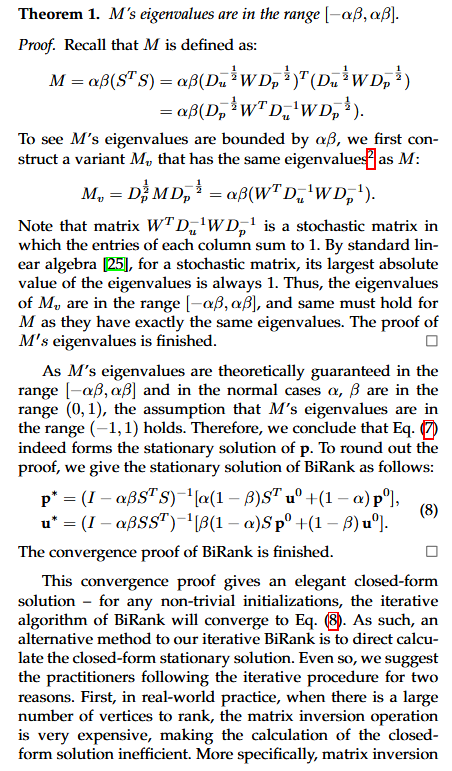

In [82]:
prior_vector = np.zeros(num_claims)
for i in range(1, num_claims + 1):
    if G.nodes[f"C{i}"]['label'] == 'fraud':
        prior_vector[i - 1] = 1

print("Prior vector:", prior_vector)

Prior vector: [0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [83]:
prior_vector.shape

(50,)

In [84]:
claims = np.linalg.inv( np.identity(ST_S.todense().shape[0]) - 0.85 * ST_S ) * ( 0.15 * prior_vector.reshape((50,1)) )
claims.flatten()

matrix([[0.204, 0.304, 0.381, 0.465, 0.294, 0.388, 0.304, 0.419, 0.33 ,
         0.298, 0.231, 0.386, 0.471, 0.275, 0.461, 0.195, 0.256, 0.463,
         0.181, 0.382, 0.255, 0.197, 0.196, 0.461, 0.175, 0.394, 0.321,
         0.204, 0.45 , 0.297, 0.266, 0.376, 0.22 , 0.45 , 0.236, 0.265,
         0.198, 0.177, 0.284, 0.276, 0.254, 0.393, 0.184, 0.197, 0.27 ,
         0.223, 0.203, 0.085, 0.16 , 0.175]])

In [85]:
claims_birank['birank_score'].values

array([0.158, 0.298, 0.343, 0.255, 0.31 , 0.186, 0.261, 0.421, 0.305,
       0.247, 0.199, 0.154, 0.27 , 0.449, 0.248, 0.387, 0.2  , 0.261,
       0.334, 0.402, 0.221, 0.197, 0.179, 0.275, 0.21 , 0.193, 0.456,
       0.189, 0.17 , 0.255, 0.207, 0.168, 0.363, 0.167, 0.444, 0.287,
       0.374, 0.346, 0.501, 0.24 , 0.247, 0.197, 0.217, 0.358, 0.348,
       0.177, 0.193, 0.269, 0.398, 0.211])

In [86]:
parties = np.linalg.inv( np.identity(S_ST.todense().shape[0]) - 0.85 * S_ST) * (0.15 * Su.todense() * prior_vector.reshape((50,1)))
parties.flatten()

matrix([[0.337, 0.406, 0.306, 0.262, 0.297, 0.334, 0.352, 0.258, 0.302,
         0.422, 0.368, 0.215, 0.243, 0.266, 0.259, 0.345, 0.274, 0.229,
         0.345, 0.225, 0.341, 0.323, 0.362, 0.302, 0.31 , 0.259, 0.296,
         0.35 , 0.205, 0.246, 0.211, 0.381, 0.207, 0.28 , 0.233, 0.339,
         0.382, 0.36 , 0.271, 0.169, 0.255, 0.329, 0.226, 0.38 , 0.272,
         0.273, 0.317, 0.257, 0.255, 0.107]])

In [87]:
parties_birank['birank_score'].values

array([0.279, 0.33 , 0.172, 0.313, 0.193, 0.333, 0.302, 0.26 , 0.315,
       0.303, 0.246, 0.241, 0.125, 0.277, 0.267, 0.309, 0.216, 0.234,
       0.328, 0.296, 0.316, 0.204, 0.195, 0.321, 0.282, 0.328, 0.308,
       0.262, 0.262, 0.344, 0.215, 0.208, 0.325, 0.309, 0.203, 0.35 ,
       0.204, 0.284, 0.383, 0.228, 0.305, 0.212, 0.384, 0.326, 0.295,
       0.327, 0.16 , 0.268, 0.315, 0.19 ])

## 1.2 A Note on Sparse Coordinate Matrix

$$
\text{claims_birank} = \alpha Wp + (1-\alpha) c^0,  
\text{parties_birank} = W^T c
$$
**W** is the symmetrically normalized weight matrix  
**c, p** are randomly initialized vector to hot start  
**c^0** is vector of know fraudulent claims (investigated and found to be fraudulent)  
$\alpha$ controls the trade-off between importance of network structure and query vector of known fraudulent claims

Higher $\alpha$ : More weightage placed on network structure, less weightage on prior information of known fraudulent claim  
Lower $\alpha$ : Less weightage placed on network structure, more weightage on prior information of known fraudulent claim

In [91]:
from networkx.algorithms import bipartite
print(bipartite.is_bipartite(G))
# rows = ['P1', 'P2', 'P3', 'P4']
# cols = ['C1', 'C2', 'C3', 'C4', 'C5']
# W = bipartite.matrix.biadjacency_matrix(G, row_order = rows, column_order = cols)
# W.todense()

rows = [f"P{i}" for i in range(1, num_parties + 1)]
cols = [f"C{i}" for i in range(1, num_claims + 1)]

# Check if the graph is bipartite
print("Is the graph bipartite?", bipartite.is_bipartite(G))

# Calculate the biadjacency matrix
W = bipartite.biadjacency_matrix(G, row_order=rows, column_order=cols)
print("Biadjacency matrix:")
print(W.todense())

print(num_claims, num_parties)

True
Is the graph bipartite? True
Biadjacency matrix:
[[0.    0.169 0.258 ... 0.    0.    0.   ]
 [0.    0.    0.236 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.189 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]
50 50


Constructing the **W** unnormalized weight matrix to parse into the birank algorithm

In [92]:
bn.df['parties_index'].values # i

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,
        3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14,
       15, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 18, 18,
       18, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22,
       22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26,
       26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29,
       29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33,
       33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37,
       37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 40, 40, 40, 40, 41, 41, 41,
       41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44,
       44, 45, 45, 45, 45, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49])

In [93]:
bn.df['claims_index'].values # j

array([ 0,  1,  2,  3,  4,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        4,  0,  6, 16, 11, 16, 17,  7,  1, 18, 19, 14, 20, 16,  1, 21, 22,
       23, 24, 13, 18, 25, 26, 20, 27,  3, 28, 29, 30, 31, 32, 33, 20,  8,
       14, 30,  6, 34, 10, 35, 30, 28, 30, 23, 36, 27,  4, 37,  3,  1,  4,
       38, 20, 12, 26,  5, 39, 17, 21, 29, 17,  4, 34, 40,  8, 12, 13, 29,
        7, 40, 38, 13,  8, 13, 41,  8, 10, 19, 16, 40, 31, 14, 14,  9, 33,
        3,  9, 42, 35, 27,  7, 26, 31, 39,  6,  1, 43,  1, 15,  7, 44, 45,
       23, 38, 26, 46, 26, 12, 11, 45, 46, 35, 37, 42,  8, 24, 47, 35, 29,
       42, 44, 35,  1, 42, 10, 29, 41, 28, 23, 39, 44, 34, 48, 46, 26, 34,
       49,  3,  9, 22, 40,  0, 32, 44, 23, 36, 41, 25, 33, 39, 17, 43,  3,
        9, 23, 12, 21, 19, 48, 38, 49, 36,  6, 38, 44, 17, 13, 17,  8,  5,
       45, 48, 43, 44, 35, 34, 39, 25, 22, 26,  2,  6, 49, 30,  8,  9,  4,
       34, 40, 12, 32, 15, 35, 33, 28, 29, 37, 44, 14,  4, 24, 19, 38, 38])

In [94]:
n = len(bn.df['parties_index'].values)
weight = np.ones(n) # data
weight

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

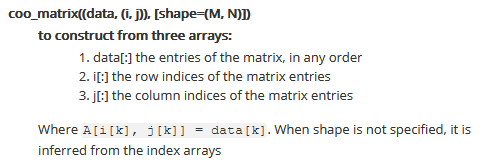

In [95]:
import scipy.sparse as spa
W = spa.coo_matrix(
            (
                weight,
                (bn.df['parties_index'].values, bn.df['claims_index'].values)
            )
        )
W.todense()

matrix([[1., 1., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Notice this is different from the adjacency matrix returned by NetworkX.  
This is because the columns in the W matrix is ['C2', 'C1', 'C3', 'C4', 'C5'], in the order of the `Claims` column in the given `edgelist_df`

In [96]:
from networkx.algorithms import bipartite
import numpy as np

# Define the rows and columns
rows = [f"P{i}" for i in range(1, num_parties + 1)]
cols = [f"C{i}" for i in range(1, num_claims + 1)]

# Check if the graph is bipartite
print("Is the graph bipartite?", bipartite.is_bipartite(G))

# Calculate the biadjacency matrix
W = bipartite.biadjacency_matrix(G, row_order=rows, column_order=cols)
print("Biadjacency matrix:")
print(W.todense())


Is the graph bipartite? True
Biadjacency matrix:
[[0.    0.169 0.258 ... 0.    0.    0.   ]
 [0.    0.    0.236 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.189 0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


This is equal now

## 1.3 A Note on prior vector

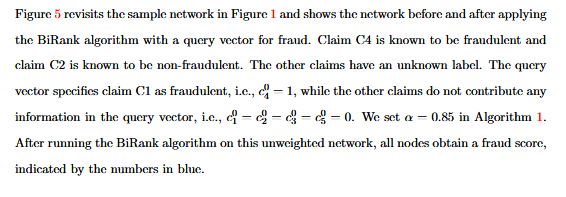

In order words, the prior vector will be:
prior = [0, 0, 0, 1, 0]  
prior[3] == 1 because 'C4' is known to be fraudulent, the rest == 0

In [97]:
prior = [node for node in G.nodes if G.nodes[node].get('label') == 'fraud']
# Generate prior vector
temp_df = pd.DataFrame(
    bn.df['Claims'].unique(),
    columns=['Claims']
).reset_index()

temp_df['prior'] = np.where(temp_df['Claims'].isin(prior), 1, 0)
temp_df

,index,Claims,prior
0,0,C11,0
1,1,C2,0
2,2,C3,1
3,3,C33,0
4,4,C37,0
5,5,C22,0
6,6,C36,0
7,7,C26,1
8,8,C47,0
9,9,C21,0


In [98]:
prior_vector = temp_df['prior'].values
prior_vector

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0])

## 1.4 A Note on why we use Birank instead of PageRank
`PageRank` scores nodes in a network to bring out nodes that are important in the network, we personalize `PageRank` to bring out the nodes that are important to a set of specific nodes, which in our perspective will be the known Fraduluent Claims. The resulting scores are then personalized towards these known fraudulent nodes, to reflect a preference for this nodes based on the homophilic nature of the network.

When calculating node centrality measures in bipartite networks, a common approach is to apply `PageRank` on the one-mode projection of the network. Basically for two sets $U$ and $P$, while there won't be any edges within nodes in $U$, but if two vertices in $U$ are connected via some node in $P$ as in our case, a projection onto $U$ will cause the information of the intermediate node in $P$ that causes $u_1$ and $u_2$ to be connected to be lost. You will lose the information on the intermediate node that connects $u_1$ and $u_2$ and distort the network topology.  

For better node ranking on bipartite networks wrt to our network structure, as is our use case with `Claims` and `Parties`, it is preferable to use a ranking algorithm that fully accounts for the topology of both modes of the network.

In [99]:
bn = Bipartite()
# prior vector uses only known fradulent claims as query vector in BiRank
bn.set_edgelist(edgelist_df,  parties_col='Parties', claims_col='Claims')
# prior vector must be a list of the Claims ID known to be fraudulent
prior = [node for node in G.nodes if G.nodes[node].get('label') == 'fraud']
parties_birank, claims_birank = bn.generate_birank(normalizer="BiRank", alpha=0.85, beta=1, max_iter=200, tol=1.0e-4, prior=prior, verbose=False)
#β = 1, since only the network structure matters in the absence of the query vector.
claims_birank

No. of known prior fraudulent flags: 15.0 Length of prior_vector: 50


,Claims,birank_score
0,C11,0.158467
1,C2,0.297958
2,C3,0.342682
3,C33,0.255063
4,C37,0.310250
5,C22,0.185892
6,C36,0.261084
7,C26,0.420991
8,C47,0.305166
9,C21,0.247128


In [100]:
# new_cols = {"Claims": "node", "Parties": "node"}
# df = parties_birank.rename(columns=new_cols).append(claims_birank.rename(columns=new_cols)).reset_index(drop=True)
# df

import pandas as pd

new_cols = {"Claims": "node", "Parties": "node"}
df = pd.concat([parties_birank.rename(columns=new_cols), claims_birank.rename(columns=new_cols)], ignore_index=True)
df

,node,birank_score
0,P1,0.278768
1,P2,0.330195
2,P3,0.172450
3,P4,0.312697
4,P5,0.193439
...,...,...
95,C38,0.176944
96,C44,0.192736
97,C8,0.269467
98,C6,0.398005


## Feature Engineering

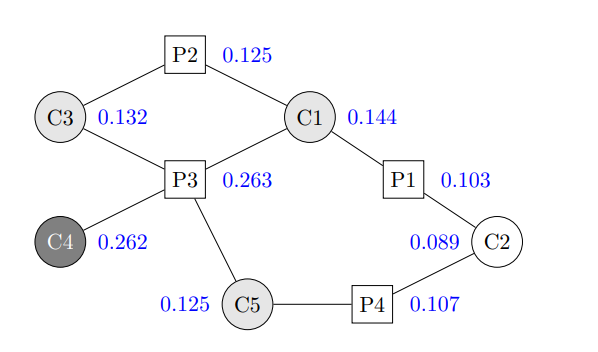

In [101]:
def neighborhood(G, node, n):
    '''
    https://stackoverflow.com/questions/22742754/finding-the-n-degree-neighborhood-of-a-node
    Returns a list of nodes in the n-order neighborhood of
    '''
    path_lengths = nx.single_source_dijkstra_path_length(G, node, weight=None)
    return [node for node, length in path_lengths.items()
                    if length == n]

def generate_n1_q1(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_q1 = temp_df['birank_score'].quantile(0.25)
    return n1_q1

def generate_n1_q1(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_q1 = temp_df['birank_score'].quantile(0.25)
    return n1_q1

def generate_n1_med(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_med = temp_df['birank_score'].quantile(0.5)
    return n1_med

def generate_n1_max(G, df, x):
    n1 = neighborhood(G, x, 1)
    mask = df['node'].isin(n1)
    temp_df = df[mask]
    n1_max = temp_df['birank_score'].max()
    return n1_max

def generate_n2_q1(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_q1 = temp_df['birank_score'].quantile(0.25)
    return n2_q1

def generate_n2_med(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_med = temp_df['birank_score'].quantile(0.5)
    return n2_med

def generate_n2_max(G, df, x):
    n2 = neighborhood(G, x, 2)
    mask = df['node'].isin(n2)
    temp_df = df[mask]
    n2_max = temp_df['birank_score'].max()
    return n2_max

def generate_n1_size(G, df, x):
    '''
    Size of first order neighborhood is number of claims
    in which Involed Parties are engaged in
    Bipartite network: First Order Neighborhood of Claims 
    is always an Involved Party
    '''
    n1 = neighborhood(G, x, 1)
    n1_size = len(n1)
    return n1_size

def generate_n2_size(G, df, x):
    '''
    Size of the second order neighborhood is number of Claims
    in which Involed Parties are engaged in
    Due to the nature of the Bipartite network, 2nd Order 
    Neighborhood of Involved Parties is the number of Claims
    it is engaged in
    '''
    n2 = neighborhood(G, x, 2)
    n2_size = len(n2)
    return n2_size

In [102]:
df['n1_q1'] = df['node'].apply(lambda x: generate_n1_q1(G, df, x))
df['n1_med'] = df['node'].apply(lambda x: generate_n1_med(G, df, x))
df['n1_max'] = df['node'].apply(lambda x: generate_n1_max(G, df, x))
df['n2_q1'] = df['node'].apply(lambda x: generate_n2_q1(G, df, x))
df['n2_med'] = df['node'].apply(lambda x: generate_n2_med(G, df, x))
df['n2_max'] = df['node'].apply(lambda x: generate_n2_max(G, df, x))
df['n1_size'] = df['node'].apply(lambda x: generate_n1_size(G, df, x))
df['n2_size'] = df['node'].apply(lambda x: generate_n2_size(G, df, x))

df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size
0,P1,0.278768,0.255063,0.297958,0.342682,0.250389,0.294640,0.332657,5,19
1,P2,0.330195,0.250617,0.283125,0.420991,0.236853,0.283882,0.332657,6,19
2,P3,0.172450,0.176430,0.199122,0.270357,0.241064,0.283882,0.328384,3,9
3,P4,0.312697,0.294568,0.348861,0.449182,0.261846,0.286704,0.328384,4,18
4,P5,0.193439,0.157285,0.179276,0.261084,0.222131,0.270181,0.332657,4,12
...,...,...,...,...,...,...,...,...,...,...
95,C38,0.176944,0.236805,0.261594,0.307596,0.192736,0.270357,0.501500,3,9
96,C44,0.192736,0.284595,0.307596,0.308994,0.210868,0.270357,0.501500,3,9
97,C8,0.269467,0.344271,0.344271,0.344271,0.216847,0.255048,0.347660,1,5
98,C6,0.398005,0.353933,0.382842,0.383789,0.240268,0.347660,0.501500,3,9


In [111]:
def generate_n2_ratioFraud(G, x):
    if x not in G:
        return 0  # Return default value if node does not exist in the graph
    
    frauds_count = 0
    # Claims
    if x.startswith("C"):
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 'fraud': 
                frauds_count += 1
        if frauds_count == 0: 
            return 0
        else:
            n2_ratioFraud = frauds_count / n2_size
            return n2_ratioFraud        

def generate_n2_ratioNonFraud(G, x):
    if x not in G:
        return 0  # Return default value if node does not exist in the graph
    
    no_frauds_count = 0
    # Claims
    if x.startswith("C"):
        claims = neighborhood(G, x, 2)
        n2_size = len(claims)
        for claim in claims:
            if G.nodes[claim]['label'] == 'no_fraud': 
                no_frauds_count += 1
        if no_frauds_count == 0:
            return 0
        n2_ratioNonFraud = no_frauds_count / n2_size
        return n2_ratioNonFraud  

def generate_n2_binFraud(G, x):
    if x not in G:
        return 0  # Return default value if node does not exist in the graph
    
    n2_binFraud = 0
    # Claim
    if x.startswith("C"):              
        n2_binFraud = 0
        claims = neighborhood(G, x, 2)
        for claim in claims:
            if G.nodes[claim]['label'] == 'fraud': 
                n2_binFraud = 1 
                return n2_binFraud

    # Involved Parties
    subgraph_nodes = list(nx.single_source_shortest_path(G, x, 2).keys())
    subgraph = G.subgraph(subgraph_nodes)
    fraud_dict = nx.get_node_attributes(subgraph, 'fraudulent')
    n2 = neighborhood(subgraph, x, 2)
    n2_size = len(n2)

    for claim in n2:
        if claim not in fraud_dict: 
            n2_binFraud = 1

    return n2_binFraud


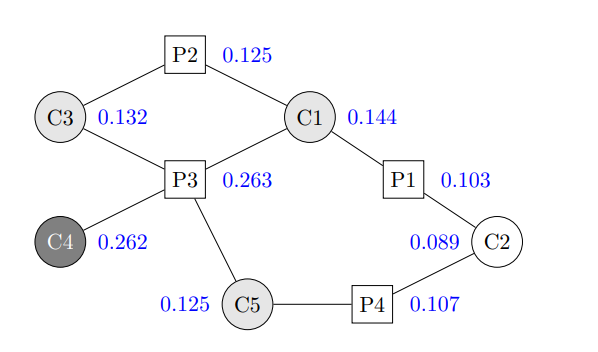

In [114]:
df['n2_ratioFraud'] = df['node'].apply(lambda x: generate_n2_ratioFraud(G, x))
df['n2_ratioNonFraud'] = df['node'].apply(lambda x: generate_n2_ratioNonFraud(G, x))
df['n2_binFraud'] = df['node'].apply(lambda x: generate_n2_binFraud(G, x))

df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size,n2_ratioFraud,n2_ratioNonFraud,n2_binFraud
0,P1,0.278768,0.255063,0.297958,0.342682,0.250389,0.294640,0.332657,5,19,NaN,NaN,0
1,P2,0.330195,0.250617,0.283125,0.420991,0.236853,0.283882,0.332657,6,19,NaN,NaN,0
2,P3,0.172450,0.176430,0.199122,0.270357,0.241064,0.283882,0.328384,3,9,NaN,NaN,0
3,P4,0.312697,0.294568,0.348861,0.449182,0.261846,0.286704,0.328384,4,18,NaN,NaN,0
4,P5,0.193439,0.157285,0.179276,0.261084,0.222131,0.270181,0.332657,4,12,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,C38,0.176944,0.236805,0.261594,0.307596,0.192736,0.270357,0.501500,3,9,0.222222,0.333333,1
96,C44,0.192736,0.284595,0.307596,0.308994,0.210868,0.270357,0.501500,3,9,0.333333,0.333333,1
97,C8,0.269467,0.344271,0.344271,0.344271,0.216847,0.255048,0.347660,1,5,0.000000,0.800000,1
98,C6,0.398005,0.353933,0.382842,0.383789,0.240268,0.347660,0.501500,3,9,0.444444,0.555556,1


In [105]:
unique_labels = df['node'].unique()
print("Unique node labels in DataFrame:", unique_labels)


Unique node labels in DataFrame: ['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13'
 'P14' 'P15' 'P16' 'P17' 'P18' 'P19' 'P20' 'P21' 'P22' 'P23' 'P24' 'P25'
 'P26' 'P27' 'P28' 'P29' 'P30' 'P31' 'P32' 'P33' 'P34' 'P35' 'P36' 'P37'
 'P38' 'P39' 'P40' 'P41' 'P42' 'P43' 'P44' 'P45' 'P46' 'P47' 'P48' 'P49'
 'P50' 'C11' 'C2' 'C3' 'C33' 'C37' 'C22' 'C36' 'C26' 'C47' 'C21' 'C46'
 'C25' 'C16' 'C4' 'C45' 'C24' 'C28' 'C19' 'C18' 'C12' 'C35' 'C14' 'C27'
 'C48' 'C5' 'C31' 'C15' 'C7' 'C40' 'C39' 'C50' 'C23' 'C32' 'C9' 'C20'
 'C17' 'C13' 'C42' 'C29' 'C1' 'C43' 'C10' 'C30' 'C34' 'C49' 'C38' 'C44'
 'C8' 'C6' 'C41']


In [106]:
for label in unique_labels:
    if label in G:
        print(f"Node {label} exists in the graph.")
    else:
        print(f"Node {label} does not exist in the graph.")


Node P1 exists in the graph.
Node P2 exists in the graph.
Node P3 exists in the graph.
Node P4 exists in the graph.
Node P5 exists in the graph.
Node P6 exists in the graph.
Node P7 exists in the graph.
Node P8 exists in the graph.
Node P9 exists in the graph.
Node P10 exists in the graph.
Node P11 exists in the graph.
Node P12 exists in the graph.
Node P13 exists in the graph.
Node P14 exists in the graph.
Node P15 exists in the graph.
Node P16 exists in the graph.
Node P17 exists in the graph.
Node P18 exists in the graph.
Node P19 exists in the graph.
Node P20 exists in the graph.
Node P21 exists in the graph.
Node P22 exists in the graph.
Node P23 exists in the graph.
Node P24 exists in the graph.
Node P25 exists in the graph.
Node P26 exists in the graph.
Node P27 exists in the graph.
Node P28 exists in the graph.
Node P29 exists in the graph.
Node P30 exists in the graph.
Node P31 exists in the graph.
Node P32 exists in the graph.
Node P33 exists in the graph.
Node P34 exists in 

In [107]:
# Iterate over unique node labels in the DataFrame
for label in unique_labels:
    # Check if the node exists in the graph
    if label not in G:
        # Assign a default value of 0 to the node in your DataFrame
        # For example, if you have a column named 'n2_ratioFraud', you can assign 0 to it
        df.loc[df['node'] == label, 'n2_ratioFraud'] = 0
        df.loc[df['node'] == label, 'n2_ratioNonFraud'] = 0
        df.loc[df['node'] == label, 'n2_binFraud'] = 0

# Optionally, you can print a message to indicate that the assignment is done
print("Assigned 0 to unique nodes that do not exist in the graph.")


Assigned 0 to unique nodes that do not exist in the graph.


In [116]:
df['n2_ratioFraud'] = df['node'].apply(lambda x: generate_n2_ratioFraud(G, x))
df['n2_ratioNonFraud'] = df['node'].apply(lambda x: generate_n2_ratioNonFraud(G, x))
df['n2_binFraud'] = df['node'].apply(lambda x: generate_n2_binFraud(G, x))

df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size,n2_ratioFraud,n2_ratioNonFraud,n2_binFraud
0,P1,0.278768,0.255063,0.297958,0.342682,0.250389,0.294640,0.332657,5,19,NaN,NaN,0
1,P2,0.330195,0.250617,0.283125,0.420991,0.236853,0.283882,0.332657,6,19,NaN,NaN,0
2,P3,0.172450,0.176430,0.199122,0.270357,0.241064,0.283882,0.328384,3,9,NaN,NaN,0
3,P4,0.312697,0.294568,0.348861,0.449182,0.261846,0.286704,0.328384,4,18,NaN,NaN,0
4,P5,0.193439,0.157285,0.179276,0.261084,0.222131,0.270181,0.332657,4,12,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,C38,0.176944,0.236805,0.261594,0.307596,0.192736,0.270357,0.501500,3,9,0.222222,0.333333,1
96,C44,0.192736,0.284595,0.307596,0.308994,0.210868,0.270357,0.501500,3,9,0.333333,0.333333,1
97,C8,0.269467,0.344271,0.344271,0.344271,0.216847,0.255048,0.347660,1,5,0.000000,0.800000,1
98,C6,0.398005,0.353933,0.382842,0.383789,0.240268,0.347660,0.501500,3,9,0.444444,0.555556,1


In [120]:
claims_labels = {node: G.nodes[node]['label'] for node in G.nodes if node.startswith('C')}
claims_labels

{'C1': 'no_fraud',
 'C2': 'no_fraud',
 'C3': 'fraud',
 'C4': 'fraud',
 'C5': 'no_fraud',
 'C6': 'fraud',
 'C7': 'unknown',
 'C8': 'fraud',
 'C9': 'no_fraud',
 'C10': 'unknown',
 'C11': 'no_fraud',
 'C12': 'fraud',
 'C13': 'fraud',
 'C14': 'no_fraud',
 'C15': 'fraud',
 'C16': 'no_fraud',
 'C17': 'no_fraud',
 'C18': 'fraud',
 'C19': 'no_fraud',
 'C20': 'fraud',
 'C21': 'unknown',
 'C22': 'unknown',
 'C23': 'no_fraud',
 'C24': 'fraud',
 'C25': 'unknown',
 'C26': 'fraud',
 'C27': 'no_fraud',
 'C28': 'unknown',
 'C29': 'fraud',
 'C30': 'no_fraud',
 'C31': 'unknown',
 'C32': 'fraud',
 'C33': 'no_fraud',
 'C34': 'fraud',
 'C35': 'no_fraud',
 'C36': 'unknown',
 'C37': 'no_fraud',
 'C38': 'unknown',
 'C39': 'unknown',
 'C40': 'no_fraud',
 'C41': 'no_fraud',
 'C42': 'fraud',
 'C43': 'no_fraud',
 'C44': 'no_fraud',
 'C45': 'no_fraud',
 'C46': 'unknown',
 'C47': 'unknown',
 'C48': 'unknown',
 'C49': 'no_fraud',
 'C50': 'unknown'}

In [123]:
claims_df = df[df['node'].str.startswith('C')].copy()

# Set target column based on label
# Add 'target' column based on labels
claims_df['target'] = [1 if claims_labels.get(node, '') in ['fraud', 'no_fraud'] else 0 for node in claims_df['node']]

# Display the resulting DataFrame
claims_df

,node,birank_score,n1_q1,n1_med,n1_max,n2_q1,n2_med,n2_max,n1_size,n2_size,n2_ratioFraud,n2_ratioNonFraud,n2_binFraud,target
50,C11,0.158467,0.198237,0.203035,0.278768,0.211746,0.251096,0.342682,3,10,0.100000,0.500000,1,1
51,C2,0.297958,0.272765,0.282063,0.332657,0.217777,0.261172,0.420991,7,22,0.318182,0.545455,1,1
52,C3,0.342682,0.302466,0.326164,0.330195,0.192817,0.255063,0.456070,3,13,0.153846,0.461538,1,1
53,C33,0.255063,0.269763,0.281325,0.308994,0.192736,0.255048,0.456070,6,21,0.285714,0.476190,1,1
54,C37,0.310250,0.272029,0.278768,0.314504,0.238063,0.286698,0.501500,7,20,0.400000,0.350000,1,1
55,C22,0.185892,0.260275,0.308534,0.330195,0.254106,0.270357,0.501500,3,11,0.363636,0.272727,1,0
56,C36,0.261084,0.232468,0.263842,0.330195,0.184173,0.230417,0.456070,6,20,0.250000,0.400000,1,0
57,C26,0.420991,0.327998,0.328384,0.332657,0.246928,0.270357,0.456070,5,19,0.263158,0.368421,1,1
58,C47,0.305166,0.258080,0.295109,0.330195,0.210868,0.255048,0.501500,8,25,0.280000,0.400000,1,0
59,C21,0.247128,0.223247,0.289261,0.330195,0.207886,0.258073,0.456070,6,22,0.227273,0.500000,1,0


In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define features (X) and target (y)
X = claims_df[['birank_score', 'n1_size', 'n2_size', 'n2_ratioFraud', 'n2_ratioNonFraud', 'n2_binFraud']]
y = claims_df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize logistic regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict on the testing set
y_pred = logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7


In [126]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Calculate AUROC
auroc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print("AUROC:", auroc)

# Calculate AUPR
aupr = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])
print("AUPR:", aupr)


AUROC: 0.380952380952381
AUPR: 0.704421768707483


Accuracy: 0.7
AUROC: 0.380952380952381
AUPR: 0.704421768707483


/Users/pnijhara/Desktop/social_network_analysis_birank/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/pnijhara/Desktop/social_network_analysis_birank/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/pnijhara/Desktop/social_network_analysis_birank/venv/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^

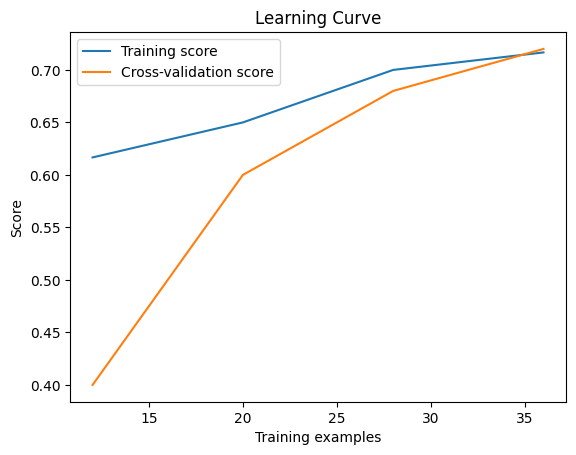

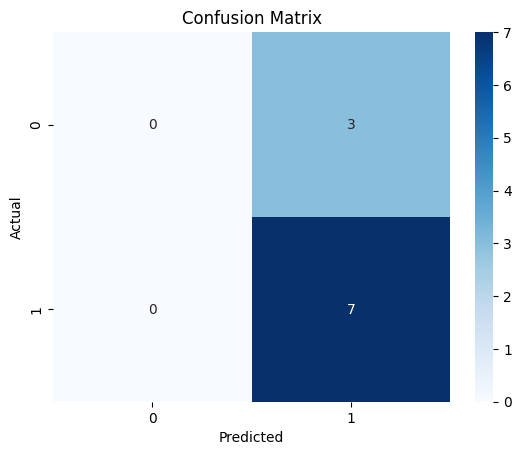

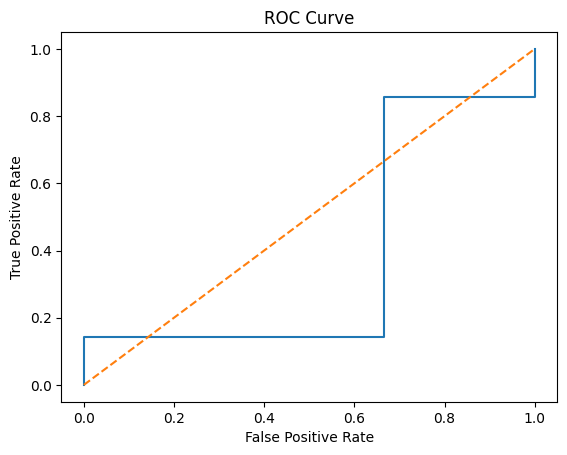

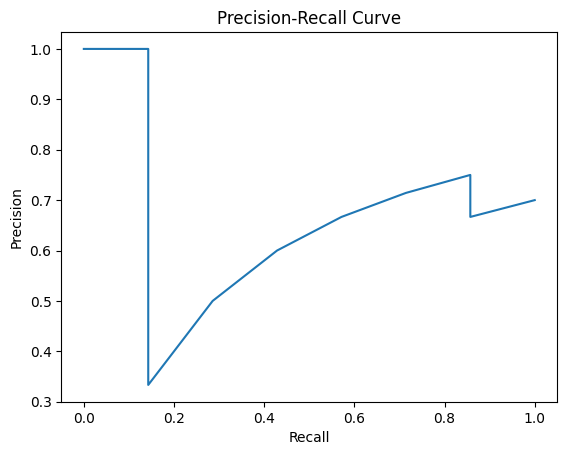

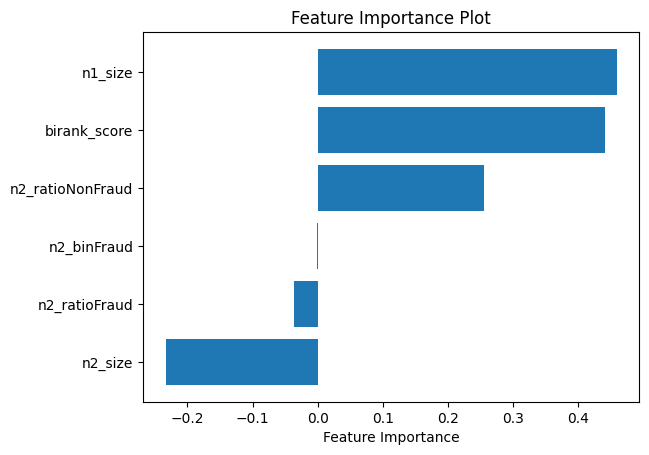

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define features (X) and target (y)
X = claims_df[['birank_score', 'n1_size', 'n2_size', 'n2_ratioFraud', 'n2_ratioNonFraud', 'n2_binFraud']]
y = claims_df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize logistic regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict on the testing set
y_pred = logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate AUROC
auroc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print("AUROC:", auroc)

# Calculate AUPR
aupr = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])
print("AUPR:", aupr)

# Plot learning curve
train_sizes, train_scores, valid_scores = learning_curve(logreg, X, y, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, valid_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot feature importance
feature_importance = logreg.coef_[0]
sorted_idx = np.argsort(feature_importance)
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()


In [129]:
print(claims_df['target'].unique())


[1 0]
